In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import requests
import json
import time
import sys
import datetime as dt
import matplotlib.dates as mdates
%matplotlib notebook

In [119]:
movies_data = pd.read_csv("ml-latest-small/movies.csv")
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [120]:
ratings_data = pd.read_csv("ml-latest-small/ratings.csv")
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [121]:
PH_movies_data = pd.read_csv("PhysicsHouseMovieNightMovies.csv")
#PH_movies_data['movieId'].astype('int')
PH_movies_data.head()

,Date,Movie,movieId
0,1/20/2019,Baby Driver,171763.0
1,1/13/2019,Song of the Sea,117444.0
2,1/6/2019,Brick,44761.0
3,12/16/2018,Pitch Perfect,96588.0
4,12/9/2018,12 Dates of Christmas,NaN


In [122]:
PH_ratings_data = pd.read_csv("PhysicsHouseMovieNightRatings_Responses.csv")
mov_names = list(PH_ratings_data.keys())
mov_names.pop()
mov_names.pop(0)

titles=[]
columns = {}
for i in range(0, len(mov_names)):
    m = re.split('\[|\]',mov_names[i])
    title = m[-2]
    titles.append(title)
    columns[mov_names[i]] = title
PH_ratings_data=PH_ratings_data.rename(index=str, columns=columns)
PH_ratings_data.head()

,Timestamp,Baby Driver,Song of the Sea,Brick,Pitch Perfect,12 Dates of Christmas,The Greatest Showman,The Wind Rises,My Life as a Zucchini,American Made,...,Get Out,The Hidden Fortress,A Fish Called Wanda,Akira,Best in Show,Robin Hood Men in Tights,Kubo and the Two Strings,Attack the Block,"The Good, the Bad, and the Ugly",What is your name?
0,1/24/2019 18:46:04,4.0,4.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,...,4.0,2.0,NaN,1.0,5.0,2.0,4.0,4.0,4.0,Joe
1,1/24/2019 18:57:33,4.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,3.0,...,5.0,2.0,4.0,1.0,4.0,3.0,4.0,4.0,4.0,Glenn Leung
2,1/24/2019 19:39:01,4.0,4.0,2.0,NaN,NaN,NaN,4.0,5.0,4.0,...,4.0,NaN,3.0,0.0,5.0,5.0,4.0,NaN,2.0,Emily Yang
3,1/24/2019 20:53:07,3.0,5.0,NaN,5.0,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jackie
4,1/24/2019 21:39:49,4.0,5.0,3.0,NaN,NaN,2.0,4.0,5.0,4.0,...,4.0,3.0,5.0,1.0,3.0,4.0,NaN,NaN,NaN,Zach


In [161]:
years = []
ratings = []
imdb_scores = []
meta_scores = []
PH_scores = []
imdbIDs = []
moviedb_ids = []
directors = []
directorgenders = []

missing_count=0
for index, row in PH_movies_data.iterrows():
    sys.stdout.write("\r" + str(index))
    sys.stdout.flush()
    time.sleep(0.1)
    title = row['Movie']
    parameters = {"t": title, "apikey": 'bcbfd86f'}
    response = requests.get("http://www.omdbapi.com/", params=parameters)
    data = response.json()
    
    if(data['Response']=='False'):
        print(title)
        print('\tNot Found!',data)
        years.append('0')
        ratings.append('0')
        imdb_scores.append('0')
        imdbIDs.append('N/A')
        meta_scores.append(0.0)
        missing_count += 1
    else:        
        years.append(data['Year'])
        ratings.append(data['Rated'])
        imdb_scores.append(float(data['imdbRating'])/2)
        imdbIDs.append(data['imdbID'])
        if(data['Metascore']=='N/A'):
            meta_scores.append(0.0)
        else:
            meta_scores.append(5*float(data['Metascore'])/100)
    
    PH_scores.append(PH_ratings_data[title].mean())
    
    imdbID = imdbIDs[-1]
    moviedb_api_key = 'b13b6c1993a6c2171b30b57395e4cf9a'
    parameters = {"api_key": moviedb_api_key, "external_source": "imdb_id"}
    response = requests.get("https://api.themoviedb.org/3/find/"+imdbID, params=parameters)
    #print(title)
    #print(response.json())
    response = response.json()
    if(len(response['movie_results'])==0):
        directors.append('N/A')
        directorgenders.append(0)
        moviedb_ids.append('N/A')
        continue
    moviedb_id = response['movie_results'][0]['id']
    moviedb_ids.append(moviedb_id)
    
    parameters = {"api_key": moviedb_api_key}
    response = requests.get("https://api.themoviedb.org/3/movie/"+str(moviedb_id)+"/credits", params=parameters)
    
    response=response.json()
    cast = response['cast']
    crew = response['crew']
    
    found = False
    for i in range(0, len(crew)):
        if crew[i]['job']=='Director':
            directors.append(crew[i]['name'])
            directorgenders.append(crew[i]['gender'])
            found = True
            break
    if(not found):
        directors.append('N/A')
        directorgenders.append(0)

print('Year = ',len(years))
print('Rating = ',len(ratings))
print('Director = ',len(directors))
print('Director Gender = ',len(directorgenders))
print('Movie_DB_ID = ', len(moviedb_ids))
print('IMDB_ID = ', len(imdbIDs))
print('IMDB = ', len(imdb_scores))
print('META = ', len(meta_scores))
print('PH_rating = ', len(PH_scores))

PH_movies_data = PH_movies_data.assign(Year=years, Rating=ratings, Director = directors, DirectorGender = directorgenders, Movie_DB_ID = moviedb_ids, IMDB_ID = imdbIDs, IMDB=imdb_scores, META=meta_scores, PH_rating=PH_scores)
print(PH_movies_data.head())
print("Number missing movies = ", missing_count)

65Year =  66
Rating =  66
Director =  66
Director Gender =  66
Movie_DB_ID =  66
IMDB_ID =  66
IMDB =  66
META =  66
PH_rating =  66
         Date                  Movie   movieId  Year Rating  IMDB  PH_rating  \
0   1/20/2019            Baby Driver  171763.0  2017      R  3.80   4.000000   
1   1/13/2019        Song of the Sea  117444.0  2014     PG  4.05   4.000000   
2    1/6/2019                  Brick   44761.0  2005      R  3.70   3.142857   
3  12/16/2018          Pitch Perfect   96588.0  2012  PG-13  3.60   3.750000   
4   12/9/2018  12 Dates of Christmas       NaN  2011     PG  3.15   2.500000   

   META    IMDB_ID      Director  DirectorGender Movie_DB_ID  
0  4.30  tt3890160  Edgar Wright               2      339403  
1  4.25  tt1865505    Tomm Moore               2      110416  
2  3.60  tt0393109  Rian Johnson               2        9270  
3  3.30  tt1981677   Jason Moore               2      114150  
4  0.00  tt1846442  James Hayman               2       81393  
Number m

In [162]:
#Brothers in Blood: The Lions of Sabi Sand
#PH_movies_data['IMDB'] = PH_movies_data['IMDB']/2
PH_movies_data.head()

,Date,Movie,movieId,Year,Rating,IMDB,PH_rating,META,IMDB_ID,Director,DirectorGender,Movie_DB_ID
0,1/20/2019,Baby Driver,171763.0,2017,R,3.80,4.000000,4.30,tt3890160,Edgar Wright,2,339403
1,1/13/2019,Song of the Sea,117444.0,2014,PG,4.05,4.000000,4.25,tt1865505,Tomm Moore,2,110416
2,1/6/2019,Brick,44761.0,2005,R,3.70,3.142857,3.60,tt0393109,Rian Johnson,2,9270
3,12/16/2018,Pitch Perfect,96588.0,2012,PG-13,3.60,3.750000,3.30,tt1981677,Jason Moore,2,114150
4,12/9/2018,12 Dates of Christmas,NaN,2011,PG,3.15,2.500000,0.00,tt1846442,James Hayman,2,81393


In [163]:
PH_movie_titles = list(PH_movies_data['Movie'])
DB_movie_titles = list(movies_data['title'])
print(PH_movie_titles[:10])
print(DB_movie_titles[:10])

def movie_match(title, year, title_DB):
    words = title.split()
    num_words = len(words)
    
    if(not year in title_DB):
        return False
    
    count = 0
    for word in words:
        if(word in title_DB):
            count +=1
            
    if(count/num_words > 0.75):
        return True
    return False

movieIDs = []
found = 0
for index, row in PH_movies_data.iterrows():
    title = row['Movie']
    year = row['Year']
    #print(title, year)
    for index_DB, row_DB in movies_data.iterrows():
        title_DB = row_DB['title']
        if(movie_match(title, year, title_DB)):
            #print(title, year, title_DB)
            row['movieId'] = row_DB['movieId']
            found += 1
            continue
    sys.stdout.write("\r" + str(index))
    sys.stdout.flush()
print("Num Movies Found = ", found, "out of ", len(PH_movies_data.index))
PH_movies_data.head()

['Baby Driver', 'Song of the Sea', 'Brick', 'Pitch Perfect', '12 Dates of Christmas', 'The Greatest Showman', 'The Wind Rises', 'My Life as a Zucchini', 'American Made', 'A Quiet Place']
['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)', 'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)', 'Sudden Death (1995)', 'GoldenEye (1995)']
65Num Movies Found =  53 out of  66


,Date,Movie,movieId,Year,Rating,IMDB,PH_rating,META,IMDB_ID,Director,DirectorGender,Movie_DB_ID
0,1/20/2019,Baby Driver,171763.0,2017,R,3.80,4.000000,4.30,tt3890160,Edgar Wright,2,339403
1,1/13/2019,Song of the Sea,117444.0,2014,PG,4.05,4.000000,4.25,tt1865505,Tomm Moore,2,110416
2,1/6/2019,Brick,44761.0,2005,R,3.70,3.142857,3.60,tt0393109,Rian Johnson,2,9270
3,12/16/2018,Pitch Perfect,96588.0,2012,PG-13,3.60,3.750000,3.30,tt1981677,Jason Moore,2,114150
4,12/9/2018,12 Dates of Christmas,NaN,2011,PG,3.15,2.500000,0.00,tt1846442,James Hayman,2,81393


[datetime.date(2019, 1, 20), datetime.date(2019, 1, 13), datetime.date(2019, 1, 6), datetime.date(2018, 12, 16), datetime.date(2018, 12, 9), datetime.date(2018, 12, 2), datetime.date(2018, 11, 25), datetime.date(2018, 11, 18), datetime.date(2018, 11, 11), datetime.date(2018, 11, 4), datetime.date(2018, 10, 28), datetime.date(2018, 10, 21), datetime.date(2018, 10, 14), datetime.date(2018, 10, 7), datetime.date(2018, 9, 30), datetime.date(2018, 9, 17), datetime.date(2018, 9, 10), datetime.date(2018, 9, 9), datetime.date(2018, 9, 2), datetime.date(2018, 8, 26), datetime.date(2018, 8, 19), datetime.date(2018, 8, 12), datetime.date(2018, 8, 5), datetime.date(2018, 7, 29), datetime.date(2018, 7, 22), datetime.date(2018, 7, 15), datetime.date(2018, 7, 8), datetime.date(2018, 6, 24), datetime.date(2018, 6, 17), datetime.date(2018, 6, 10), datetime.date(2018, 6, 3), datetime.date(2018, 5, 27), datetime.date(2018, 5, 20), datetime.date(2018, 5, 6), datetime.date(2018, 4, 29), datetime.date(2018,

<IPython.core.display.Javascript object>


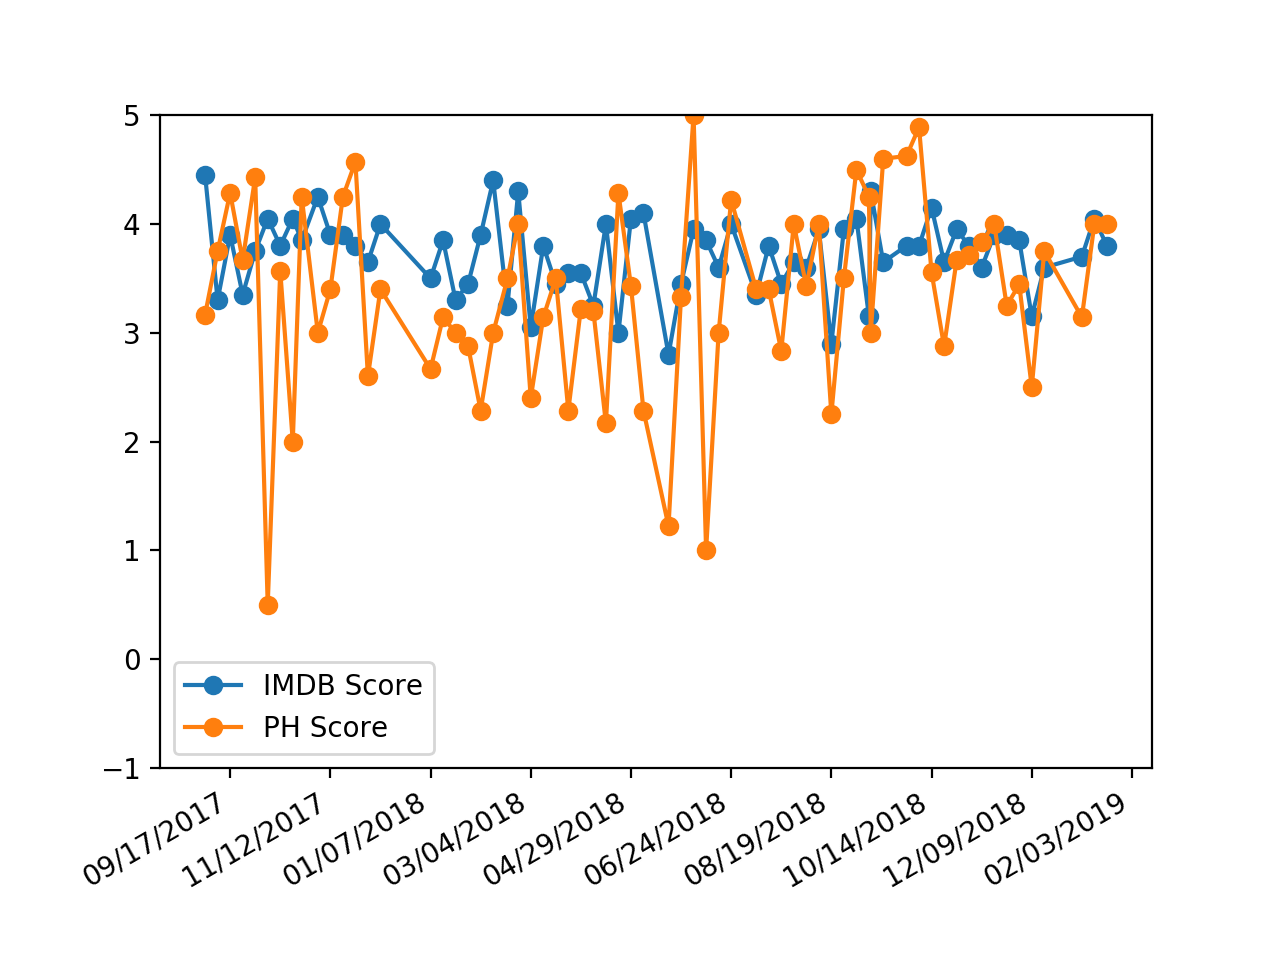

In [164]:
dates = PH_movies_data['Date'].values
IMDB_score = PH_movies_data['IMDB']
PH_score = PH_movies_data['PH_rating']

x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
print(x)
y = range(len(x)) 

plt.figure()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY, interval=8))
plt.plot(x,IMDB_score,'-o',label='IMDB Score')
plt.plot(x,PH_score,'-o',label='PH Score')
plt.gcf().autofmt_xdate()
plt.gca().set_ylim([-1,5])

plt.legend()
plt.show()

In [165]:
PH_movies_data.to_pickle("PhysicsHouseMoviesClean")

<IPython.core.display.Javascript object>


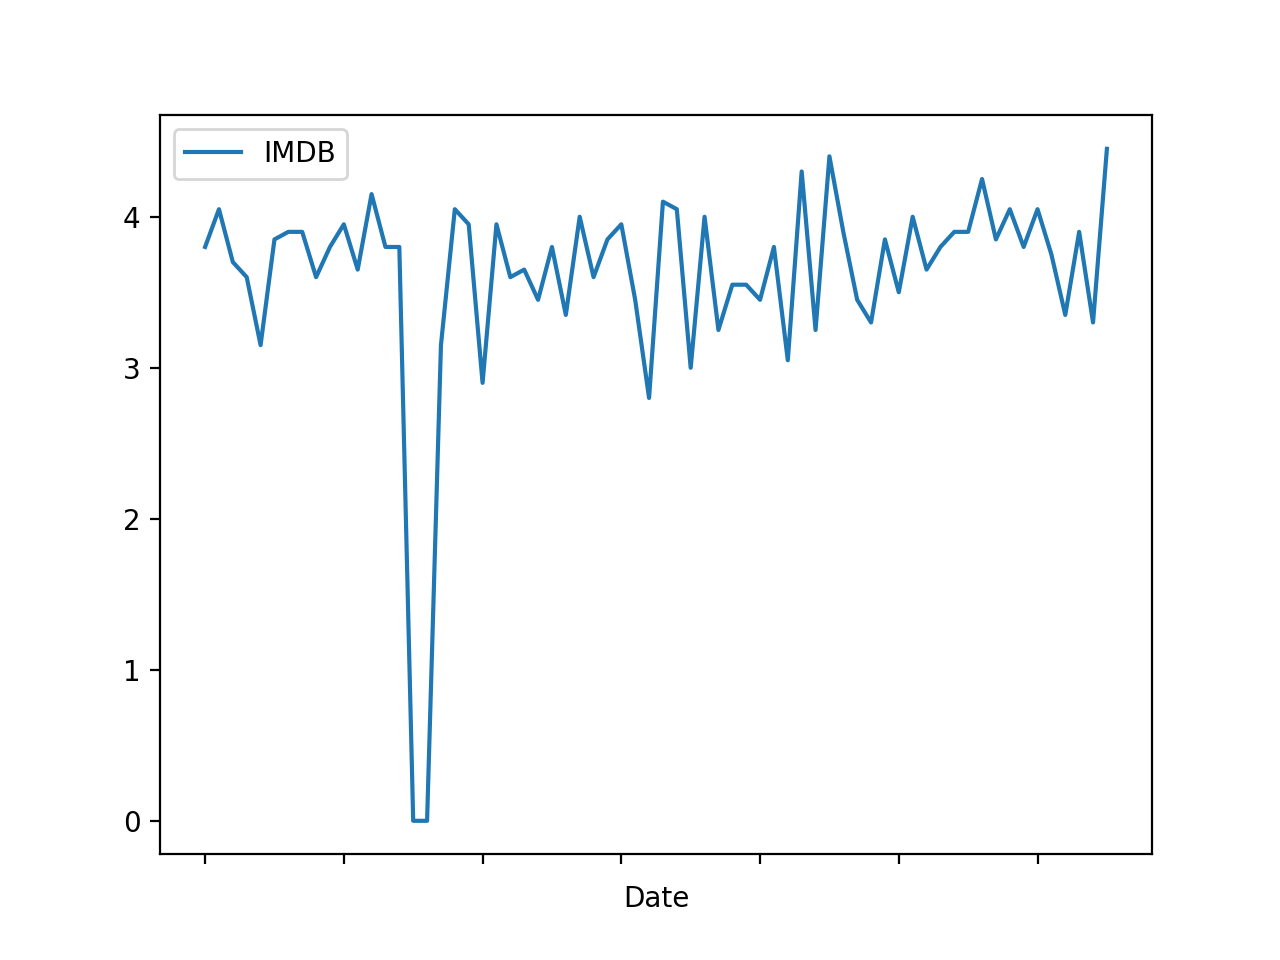

<IPython.core.display.Javascript object>


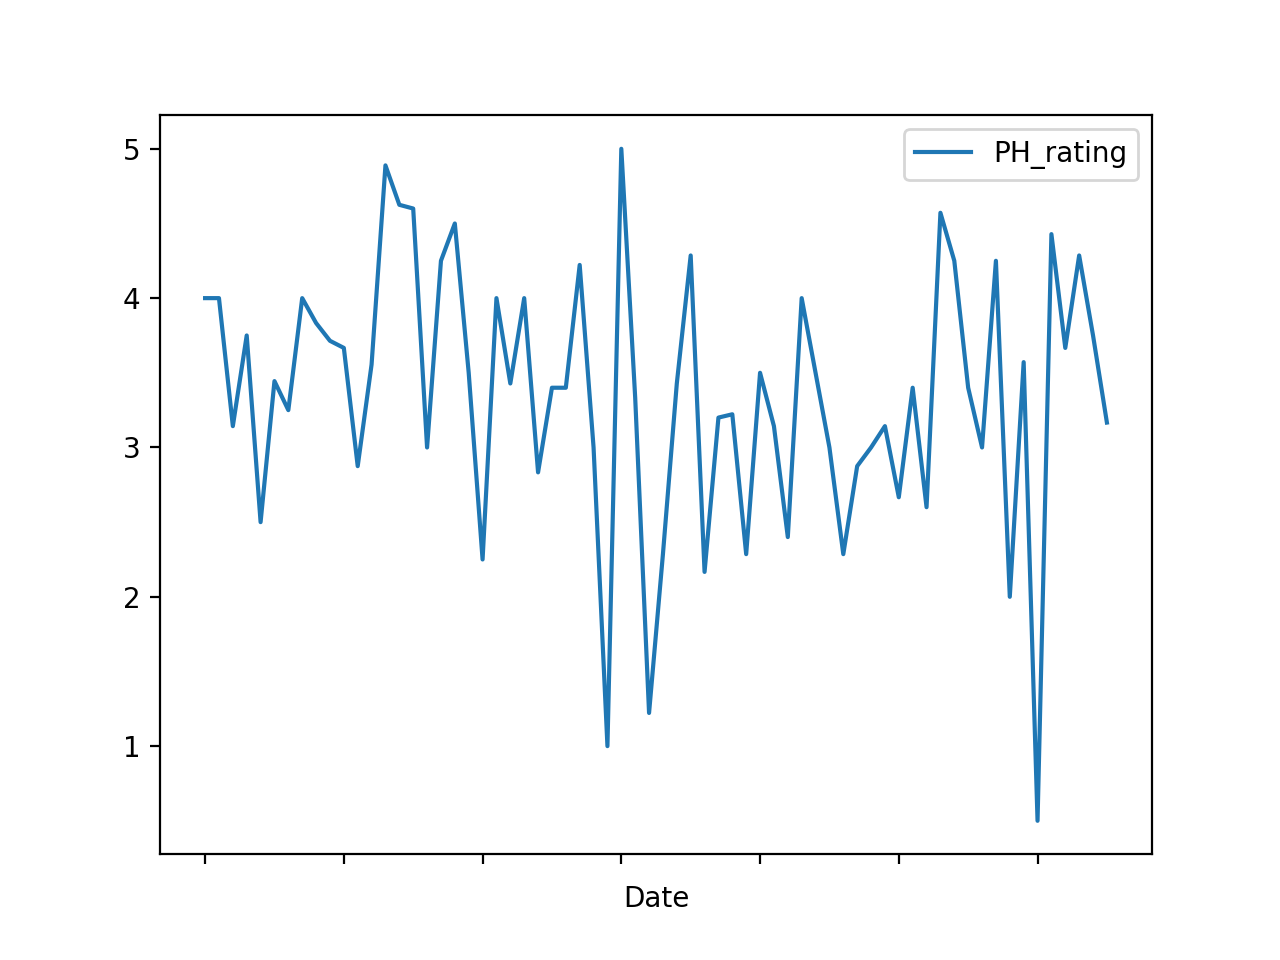

In [69]:
PH_movies_data.plot(x='Date', y='IMDB')
PH_movies_data.plot(x='Date', y='PH_rating')

In [21]:
title = "The Matrix"
parameters = {"t": title, "apikey": 'bcbfd86f'}
response = requests.get("http://www.omdbapi.com/", params=parameters)
data = response.json()
print(data)

{'Title': 'The Matrix', 'Year': '1999', 'Rated': 'R', 'Released': '31 Mar 1999', 'Runtime': '136 min', 'Genre': 'Action, Sci-Fi', 'Director': 'Lana Wachowski, Lilly Wachowski', 'Writer': 'Lilly Wachowski, Lana Wachowski', 'Actors': 'Keanu Reeves, Laurence Fishburne, Carrie-Anne Moss, Hugo Weaving', 'Plot': 'A computer hacker learns from mysterious rebels about the true nature of his reality and his role in the war against its controllers.', 'Language': 'English', 'Country': 'USA', 'Awards': 'Won 4 Oscars. Another 34 wins & 48 nominations.', 'Poster': 'https://m.media-amazon.com/images/M/MV5BNzQzOTk3OTAtNDQ0Zi00ZTVkLWI0MTEtMDllZjNkYzNjNTc4L2ltYWdlXkEyXkFqcGdeQXVyNjU0OTQ0OTY@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '8.7/10'}, {'Source': 'Rotten Tomatoes', 'Value': '88%'}, {'Source': 'Metacritic', 'Value': '73/100'}], 'Metascore': '73', 'imdbRating': '8.7', 'imdbVotes': '1,461,604', 'imdbID': 'tt0133093', 'Type': 'movie', 'DVD': '21 Sep 1999', 'BoxOffice